## ResNet
+ **作者**： 微软研究院Kaiming He等四名华人
+ **特点**：可以极快的加速超神经网络的训练，准确率也有非常大的提升。ResNet和HightwayNetwork非常类似。
+ **成就**： ILSVRC 2015冠军（error-rate 3.75%）

### ResNet灵感来源，
加深网络深度，准确率会先上升至饱和，在加深深度准确率会下降，这并不是过拟合问题（训练集，测试集误差都会增大），加入在后面添加几个全等映射层，按照理论来讲起码误差不会增大，也就是说更深的网络不应该带来训练集上误差上升。这里使用全等映射将前一层输出传到后面的思想，就是ResNet灵感来源。

### ResNet残差模块
![resnetmodule](img/resnetmodule.png)
如果某神经网络期望输出为\\(H(x)\\),把输入x传到输出作为结果，那么最终我们的期望计算方式为\\(H(x) = F(x) + x\\),也就是说，模型最终的学习目标位\\(F(x) = H(x) - x\\),ResNet相当于将学习目标改变了，不再学习完整的输出\\(H(x)\\),而是学习输出和输入的差别\\(H(x)-x\\),也就是残差
![res2module](img/res2module.png)

### ResNet不同层数的网络配置
![resconfig](img/resconfig.png)
以上面50层的为例，层数计算方法为：
1（7x7卷积层） + （3 + 4 + 6 + 3）* 3（ResNet残差module层） + 1(全连接分类层） = 50

### ResNetV2
ResNet作者第二篇相关论文Identity Mappings in Deep Residual Networks中，提出ResNetV2，和V1主要区别在于，作者通过研究ResNet残差学习单元的传播公式，发现前馈和反馈信号可以直接传输，因此，skip connection 的非线性激活函数（如ReLU）替换为Identity Mappings（y=x）,同时，每一层都是用了BatchNormailzation，这样处理后，新的残差学习单元将比以前更容易训练而且泛化性更强。ResNet类似于一个没有gates的LSTM网络，即输入x传递到后面层的过程是一直发生的，而不是学习出来的。同时，也有论文表示，ResNet基本等价于RNN且ResNet的效果类似于在多层网络间的集成方法（ensemble），另一篇论文The Power of Depth for Feedforward Neural Network 从理论上证明了加深网络比加宽网络更有效。

### Hightway Network
+ **作者**: 瑞典教授Schmidhuber，LSTM网络发明者（1997）。
HightWayNetWork目标就是解决极深的神经网络难以训练的问题，Hightway相当于修改了每一层的激活函数，之前的激活函数作用如下方程：
$$y = H(x,W_H)$$
Hightway NetWork允许保留一定比例的原始输入x，即
$$y = H(x, W_H)\cdot T(x, W_T) + x\cdot C(x, W_C)$$
其中，T为变换系数，C为保留系数，论文中令\\(T + C = 1\\),也就是说，前面一层的信息，有一定比例可以不经过矩阵乘法和非线性变换，直接传输到下一层。
Hightway Network主要通过gatingunits学习如何控制网络中的信息流，即学习原始信息应保留的比例。这个可学习的gating正是借鉴自Schmidhuber早年的LSTM循环神经网络中的gating，几百乃至上千层深的HighwayNetwork可以直接使用梯度下降算法。并可以配合多种非线性激活函数。学习极深的神经网络现在变得可行了。
Hightway Network的设计理论上允许训练任意深的网络，其优化方法基本上与网络的深度独立，而传统的神经网络结构则对深度非常敏感，训练复杂度随深度增加而急剧增加

下面实现ResNetV2网络。依然使用方便的contrib.slim库进行辅助创建

In [12]:
import collections
import tensorflow as tf
slim = tf.contrib.slim
import math
import time
import matplotlib.pyplot as plt
from datetime import datetime

我们使用collections.namedtupe设计ResNet基本Block模块组的named tuple。并用它创建Block类，但只包含数据结构，不包含具体方法。
我们要定义一个典型的Block，需要输入三个参数，分别是
+ scope
+ unit_fn
+ args
以下面的代码为例
```python
Block('block1', bottleneck, [(256, 64, 1)]*2 + [(256, 64, 2)])
```
它可以定义一个典型的Block，其中block1就是这个Block的名称或scope，bottleneck是ResNetV2中的残差学习单元。最后一个参数[(256, 64, 1)]\*2 + [(256, 64, 2)]则是这个Block的args，args是一个列表，其中每个元素都对应一个bottleneck残差学习单元，前面两个元素都是（256,64,1），最后一个是（256， 64， 2），每个元素都是一个三元tuple，即（depth， depth_bottleneck, stride）,比如（256， 64， 3）代表构建bottleneck残差学习单元中，第三层输出通道数为256， 前两层输出通道数depth_bottleneck为64， 且中间那层的步长stride为3，这个残差学习单元结构即为
[(1x1)/s1, 64],[(3x3/s2, 64)],[(1x1/s1, 256)]
在这个Block中，一共有3个bottleneck残差学习单元，除了最后一个的步长由3变为2，其余都一直。

In [2]:
class Block(collections.namedtuple('Block', ['scope', 'unit_fn', 'args'])):
    "A named tuple describing a ResNet block"

下面定义降采样subsample方法，参数包括
+ inputs 输入
+ factor 采样因子
+ scope

In [3]:
def subsample(inputs, factor, scope=None):
    if factor == 1:
        return inputs
    else :
        return slim.max_pool2d(inputs, [1, 1], stride=factor, scope=scope)

In [4]:
def conv2d_same(inputs, num_outputs, kernel_size, stride, scope=None):
    if stride == 1:
        return slim.conv2d(inputs, num_outputs, kernel_size, stride=1, padding="SAME", scope=scope)
    else :
        pad_total = kernel_size - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        inputs = tf.pad(inputs, [[0, 0], [pad_beg, pad_end], [pad_beg, pad_end], [0, 0]])
        return slim.conv2d(inputs, num_outputs, kernel_size, stride=stride, padding="VALID", scope=scope)

In [5]:
@slim.add_arg_scope
def stack_blocks_dense(net, blocks, outputs_collections=None):
    for block in blocks:
        with tf.variable_scope(block.scope, 'block', [net]) as sc:
            for i, unit in enumerate(block.args):
                with tf.variable_scope('unit_%d' %(i+1), values=[net]):
                    unit_depth, unit_depth_bottleneck, unit_stride = unit
                    net = block.unit_fn(net, depth=unit_depth, depth_bottleneck=unit_depth_bottleneck, stride=unit_stride)
            net = slim.utils.collect_named_outputs(outputs_collections, sc.name, net)
        return net

In [6]:
def resnet_arg_scope(is_training=True, weight_decay=0.0001, batch_norm_decay=0.997, batch_norm_epsilon=1e-5, batch_norm_scale=True):
    batch_norm_params = {
            'is_training': is_training,
            'decay': batch_norm_decay,
            'epsilon': batch_norm_epsilon,
            'scale': batch_norm_scale,
            'updates_collections':tf.GraphKeys.UPDATE_OPS
    }
        
    with slim.arg_scope([slim.conv2d], 
                        weights_regularizer=slim.l2_regularizer(weight_decay),
                        weights_initializer=slim.variance_scaling_initializer(),
                        activation_fn=tf.nn.relu,
                        normalizer_fn=slim.batch_norm,
                        normalizer_params=batch_norm_params):
        with slim.arg_scope([slim.batch_norm], **batch_norm_params):
            with slim.arg_scope([slim.max_pool2d], padding="SAME") as arg_sc:
                return arg_sc

In [7]:
@slim.add_arg_scope
def bottleneck(inputs, depth, depth_bottleneck, stride, outputs_collections=None, scope=None):
    with tf.variable_scope(scope, 'bottleneck_v2', [inputs]) as sc:
        depth_in = slim.utils.last_dimension(inputs.get_shape(), min_rank=4)
        preact = slim.batch_norm(inputs, activation_fn=tf.nn.relu, scope='preact')
        if depth == depth_in:
            shortcut = subsample(inputs, stride, 'shortcut')
        else:
            shortcut = slim.conv2d(preact, depth, [1,1], stride=stride, normalizer_fn=None, activation_fn=None, scope="shortcut")
            
        residual = slim.conv2d(preact, depth_bottleneck, [1,1], stride=1, scope='conv1')
        residual = conv2d_same(residual, depth_bottleneck, 3, stride, scope='conv2')
        residual = slim.conv2d(residual, depth, [1, 1], stride=1, normalizer_fn=None, activation_fn=None)
            
        output = shortcut + residual
            
        return slim.utils.collect_named_outputs(outputs_collections, sc.name, output)
    

In [8]:
def resnet_v2(inputs, blocks, num_classes=None, global_pool=True, include_root_block=True, reuse=None, scope=None):
        with tf.variable_scope(scope, 'resmet_v2', [inputs], reuse=reuse) as sc:
            end_points_collection = sc.original_name_scope + "end_points"
            with slim.arg_scope([slim.conv2d, bottleneck, stack_blocks_dense], outputs_collections=end_points_collection):
                net = inputs
                if include_root_block:
                    with slim.arg_scope([slim.conv2d], activation_fn=tf.nn.relu, normalizer_fn=None):
                        net = conv2d_same(net, 64, 7, stride=2, scope='conv1')
                    net = slim.max_pool2d(net, [3, 3], stride=2, scope='pool1')
                net = stack_blocks_dense(net, blocks)
                net = slim.batch_norm(net, activation_fn=tf.nn.relu, scope="postnorm")
                if global_pool:
                    net = tf.reduce_mean(net, [1, 2], name="pool5", keep_dims=True)
                if num_classes is not None:
                    net = slim.conv2d(net, num_classes, [1, 1], activation_fn=None, normalizer_fn=None, scope="logits")
                end_points = slim.utils.convert_collection_to_dict(end_points_collection)
                if num_classes is not None:
                    end_points['predictions'] = slim.softmax(net, scope="predictions")
                return net, end_points
        

In [9]:
def resnet_v2_50(inputs, num_classes=None, global_pool=True, reuse=None, scope='resnet_v2_50'):
    blocks = [Block('block1', bottleneck, [(256, 64, 1)]*2 + [(256, 64, 2)]),
              Block('block2', bottleneck, [(512, 128, 1)]*3 + [(512, 128, 2)]),
              Block('block3', bottleneck, [(1024, 256, 1)]*5 + [(1024, 256, 2)]),
              Block('block4', bottleneck, [(2048, 512, 1)]*3)]
    return resnet_v2(inputs, blocks, num_classes, global_pool, include_root_block=True, reuse=reuse, scope=scope)
    
def resnet_v2_101(inputs, num_classes=None, global_pool=True, reuse=None, scope='resnet_v2_101'):
    blocks = [Block('block1', bottleneck, [(256, 64, 1)]*2 + [(256, 64, 2)]),
              Block('block2', bottleneck, [(512, 128, 1)]*3 + [(512, 128, 2)]),
              Block('block3', bottleneck, [(1024, 256, 1)]*22 + [(1024, 256, 2)]),
              Block('block4', bottleneck, [(2048, 512, 1)]*3)]
    return resnet_v2(inputs, blocks, num_classes, global_pool, include_root_block=True, reuse=reuse, scope=scope)
    
def resnet_v2_152(inputs, num_classes=None, global_pool=True, reuse=None, scope='resnet_v2_152'):
    blocks = [Block('block1', bottleneck, [(256, 64, 1)]*2 + [(256, 64, 2)]),
              Block('block2', bottleneck, [(512, 128, 1)]*7 + [(512, 128, 2)]),
              Block('block3', bottleneck, [(1024, 256, 1)]*35 + [(1024, 256, 2)]),
              Block('block4', bottleneck, [(2048, 512, 1)]*3)]
    return resnet_v2(inputs, blocks, num_classes, global_pool, include_root_block=True, reuse=reuse, scope=scope)
    
def resnet_v2_200(inputs, num_classes=None, global_pool=True, reuse=None, scope='resnet_v2_152'):
    blocks = [Block('block1', bottleneck, [(256, 64, 1)]*2 + [(256, 64, 2)]),
              Block('block2', bottleneck, [(512, 128, 1)]*23 + [(512, 128, 2)]),
              Block('block3', bottleneck, [(1024, 256, 1)]*35 + [(1024, 256, 2)]),
              Block('block4', bottleneck, [(2048, 512, 1)]*3)]
    return resnet_v2(inputs, blocks, num_classes, global_pool, include_root_block=True, reuse=reuse, scope=scope)

In [10]:
def time_tensorflow_run(session, target, info_string):
    print("start time is :%s" %(datetime.now()))
    durations = []
    steps = []
    num_steps_burn_in = 10
    total_duration = 0.
    total_duration_squared = 0.
    for i in range(num_batches + num_steps_burn_in):
        start_time = time.time()
        _ = session.run(target)
        duration = time.time() - start_time
        if i >= num_steps_burn_in:
            #print('%s: step %d, duration = %.3f' % (datetime.now(), i-num_steps_burn_in, duration))
            durations.append(duration)
            steps.append(i - num_steps_burn_in)
            total_duration += duration
            total_duration_squared += duration * duration
    mn = total_duration / num_batches
    vr = total_duration_squared / num_batches - mn * mn
    sd = math.sqrt(vr)
    plt.plot(steps, durations)
    plt.xlabel("setp")
    plt.ylabel("duration/sec")
    plt.title(info_string)
    plt.show()
    print("%s:%s across %d steps, %.3f +/- %.3f sec / batch" %(datetime.now(), info_string, num_batches, mn, sd))

In [13]:
# logfile = r"D:\python\tensorflow\name_scope2"
# graph = tf.Graph()
# with graph.as_default():
#     with slim.arg_scope(resnet_arg_scope(is_training=False)):
#         inputs = tf.random_normal((32, 244, 244, 3))
#         net, end_points = resnet_v2_152(inputs, 1000)
# # 创建写入数据的对象，设定log的文件夹，以及要导出的文件的graph数据流图对象
# writer = tf.summary.FileWriter(logdir=logfile, graph=graph)
# # 写入完成之后要关闭writer对象
# writer.close()

start time is :2018-02-27 14:36:34.664009


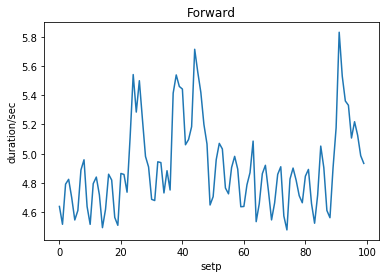

2018-02-27 14:45:33.932720:Forward across 100 steps, 4.913 +/- 0.300 sec / batch


In [11]:
batch_size = 32
height, width = 224, 224
inputs = tf.random_uniform((batch_size, height, width, 3))
with slim.arg_scope(resnet_arg_scope(is_training=False)):
    net, end_points = resnet_v2_152(inputs, 1000)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
num_batches = 100
time_tensorflow_run(sess, net, "Forward")